In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np

import random
import h5py
from keras.datasets import cifar10
from keras.models import *
from keras.layers import *
from keras.layers.core import *
from keras.layers.normalization import *
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
from keras.regularizers import *
import theano.tensor as T
import theano
from theano.tensor.shared_randomstreams import RandomStreams
from sklearn import metrics
from skimage.measure import compare_ssim
from scipy.misc import toimage
from sklearn.preprocessing import *

import os
import random
import time
from skimage import io, exposure, feature, color, transform
import matplotlib
import matplotlib.pyplot as plt
import glob

import scipy.signal as sig
import operator
import math

# for reproducibility
np.random.seed(1337) 
random.seed(1337)

Using Theano backend.
Using gpu device 1: GeForce GTX 690 (CNMeM is disabled, cuDNN 5105)


In [2]:
# parameters for sliding window, and window function (Hann)
STEP_SIZE = 480
OVERLAP_SIZE = 32
WINDOW_SIZE = STEP_SIZE + OVERLAP_SIZE
OVERLAP_FUNC = sig.hann(OVERLAP_SIZE * 2)

# directory that contains TIMIT files
TIMIT_DIR = "/home/sri/Desktop/timit"

# randomly shuffle data before partitioning into training/validation?
RANDOM_SHUFFLE = True

# sample rate of input file (used in MFCC calculation)
SAMPLE_RATE = 16000

In [3]:
from load_TIMIT import *
from windowingFunctions import *
from utility import *

In [4]:
# read in 100 WAVs from TIMIT training set
rawWaveforms = load_TIMIT_train(TIMIT_DIR, 1000)

Reading in .wav files...


In [5]:
'''
# waveform preprocessing
def preprocessWaveform(waveform):   
    return waveform, ()
   
def unpreprocessWaveform(waveform, params):
    return waveform



# window preprocessing
def preprocessWindows(windows):
    # scale window between -1 and 1
    processed = np.copy(windows)
   
    mn = np.min(processed, axis = 1)
    mx = np.max(processed, axis = 1)

    maxabs = np.maximum(np.abs(mn), np.abs(mx))

    for i in xrange(0, processed.shape[0]):
        processed[i] /= maxabs[i]
    #processed *= 0.98
   
    #processed = (processed + 1.0) / 2.0
   
    return processed, (maxabs,)

def unpreprocessWindows(windows, params):
    # scale window from [-1, 1] to [-32768, 32768]
    scl = params[0]
   
    unprocessed = np.copy(windows)
    #unprocessed /= 0.98
   
    #nprocessed = (unprocessed * 2.0) - 1.0
   
    for i in xrange(0, unprocessed.shape[0]):
        unprocessed[i] *= scl[i]

    return unprocessed
#'''

#'''
# waveform preprocessing
def preprocessWaveform(waveform):
    # scale window between -1 and 1
    mn = np.min(waveform)
    mx = np.max(waveform)
    maxabs = np.maximum(np.abs(mn), np.abs(mx))
        
    return np.copy(waveform) / maxabs, (maxabs,)
   
def unpreprocessWaveform(waveform, params):
    return np.copy(waveform) * params[0]



# window preprocessing
def preprocessWindows(windows):
    return windows, ()

def unpreprocessWindows(windows, params):
    return windows
#'''

In [6]:
# waveform preprocessing
processedWaveforms = np.copy(rawWaveforms)

# we maximize the volume of every waveform
for i in xrange(0, len(processedWaveforms)):
    processedWaveforms[i], _ = preprocessWaveform(rawWaveforms[i])


In [7]:
# extract windows
rawWindows = extractWindowsMultiple(processedWaveforms, STEP_SIZE, OVERLAP_SIZE,
                                    collapse = True)

# randomly shuffle data
if (RANDOM_SHUFFLE):
    rawWindows = np.random.permutation(rawWindows)

print "Raw windows shape: ", rawWindows.shape
print "Max: ", np.amax(rawWindows)
print "Min: ", np.amin(rawWindows)

Raw windows shape:  (101135, 512)
Max:  1.0
Min:  -1.0


In [8]:
# data augmentation goes here, at some point
augWindows = np.copy(rawWindows)

print "Aug windows shape: ", augWindows.shape

Aug windows shape:  (101135, 512)


In [9]:
processedWindows, pwParams = preprocessWindows(augWindows)

In [10]:
# reshape into vector form
processedWindows = np.reshape(processedWindows, (processedWindows.shape[0], WINDOW_SIZE, 1))

In [11]:
print processedWindows.shape

print np.mean(processedWindows, axis=None)
print np.std(processedWindows, axis=None)
print np.min(processedWindows, axis = None)
print np.max(processedWindows, axis = None)

(101135, 512, 1)
9.77603e-07
0.099766
-1.0
1.0


In [12]:
class PhaseShiftDown1D(Layer):
    """ PhaseShiftDown1D
    Takes vector of size: B x nS x F
    And returns vector: B x S x nF
    """
    def __init__(self, n, **kwargs):
        super(PhaseShiftDown1D, self).__init__(**kwargs)
        self.n = n
    
    def build(self, input_shape):
        # no trainable parameters
        self.trainable_weights = []
    
    def call(self, x, mask=None):
        r = T.reshape(x, (x.shape[0], x.shape[1] / self.n, self.n, x.shape[2]))
        r = T.transpose(r, (0, 1, 3, 2))
        r = T.reshape(r, (x.shape[0], x.shape[1] / self.n, x.shape[2] * self.n))
        return r

    def get_output_shape_for(self, input_shape):
        return (input_shape[0], input_shape[1] / self.n, input_shape[2] * self.n)
    
    def get_config(self):
        config = {'n' : self.n}
        base_config = super(PhaseShiftDown1D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [13]:
class PhaseShiftUp1D(Layer):
    """ PhaseShiftUp1D
    Takes vector of size: B x S x nF
    And returns vector: B x nS x F
    """
    def __init__(self, n, **kwargs):
        super(PhaseShiftUp1D, self).__init__(**kwargs)
        self.n = n
    
    def build(self, input_shape):
        # no trainable parameters
        self.trainable_weights = []
    
    def call(self, x, mask=None):
        r = T.reshape(x, (x.shape[0], x.shape[1], x.shape[2] / self.n, self.n))
        r = T.transpose(r, (0, 1, 3, 2))
        r = T.reshape(r, (x.shape[0], x.shape[1] * self.n, x.shape[2] / self.n))
        return r

    def get_output_shape_for(self, input_shape):
        return (input_shape[0], input_shape[1] * self.n, input_shape[2] / self.n)
    
    def get_config(self):
        config = {'n' : self.n}
        base_config = super(PhaseShiftUp1D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [14]:
# quantizes [-1.0, 1.0] into a certain number of uniform bins
class UniformQuantizer(Layer):
    def __init__(self, nbins, noise_in_train = True, **kwargs):
        self.supports_masking = True
        self.nbins = nbins
        self.noise_in_train = noise_in_train
        self.uses_learning_phase = True
        super(UniformQuantizer, self).__init__(**kwargs)

    def call(self, x, mask=None):
        # during training, add uniform noise the width of one bin
        noise_x = x + K.random_uniform(shape = K.shape(x),
                                       low = -(0.5 / (self.nbins - 1)),
                                       high = 0.5 / (self.nbins - 1))
        
        # during testing, actually quantize the thing
        qnt_x = (x + 1.0) / 2.0
        qnt_x = K.round(qnt_x * float(self.nbins - 1)) / float(self.nbins - 1)
        qnt_x = (qnt_x * 2.0) - 1.0
        
        if (self.noise_in_train):
            return K.in_train_phase(noise_x, qnt_x)
        else:
            return K.in_train_phase(x, qnt_x)

    def get_config(self):
        config = {'nbins': self.nbins}
        base_config = super(UniformQuantizer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [15]:
class SelectMax(T.Op):
    # properties attribute
    __props__ = ()
    
    def __init__(self, n):
        super(SelectMax, self).__init__()
        self.n = n
        
    def make_node(self, x):
        assert hasattr(self, '_props'), "Your version of theano is too old to support __props__."
        x = T.as_tensor_variable(x)
        return theano.Apply(self, [x], [x.type()])
    
    def perform(self, node, inputs, output_storage):
        x, = inputs
        z, = output_storage
        
        zero_idxs = np.argsort(np.abs(x), axis = -1)[:, :-self.n]
        col_idxs = np.arange(x.shape[0])[:, None]
        out = np.copy(x)
        x[col_idxs, zero_idxs] = 0
        z[0] = x
    
    def grad(self, input, output_gradients):
        x, = input
        g, = output_gradients
        
        zero_idxs = T.argsort(T.abs_(x), axis = -1)[:, :-self.n, None]
        
        idnt = T.eye(x.shape[-1]) * 0.99
        
        grad_mult = idnt[zero_idxs]
        grad_mult = T.sum(grad_mult, axis = -3)[:, 0, :]
        grad_mult = 1.0 - grad_mult
        
        grad_mult = grad_mult + 0.01
        
        out_grad = g * grad_mult
        
        return [out_grad]
        
    def infer_shape(self, node, i0_shapes):
        # output shape is same as input shape
        return i0_shapes

In [16]:
# only works with theano dawg
class OrthogonalDense(Layer):
    def __init__(self, tied_to = None, has_bias = False, **kwargs):
        super(OrthogonalDense, self).__init__(**kwargs)
        self.tied_to = tied_to
        self.has_bias = has_bias

    def build(self, input_shape):
        input_dim = input_shape[1]
        
        self.n = input_dim
        
        # we store a full matrix, but use it as a skew-symmetric one
        if (self.tied_to is None):
            self.W = np.random.uniform(-0.001, 0.001, (self.n, self.n))
            self.W = K.variable(self.W)
            self.trainable_weights = [self.W]
            
            if (self.has_bias):
                self.b = K.variable(np.zeros((self.n,)))
                self.trainable_weights = [self.W, self.b]
    
    def produce_unitary(self):
        # produce skew-symmetric matrix from W
        upper = T.triu(self.W, k = 1)
        skew = upper - K.transpose(upper)
        
        # compute approximate matrix exponential
        a = K.eye(self.n)
        unitary = K.zeros((self.n, self.n))
        
        for i in xrange(0, 11):
            c = 1.0 / math.factorial(i)

            unitary += c * a
            a = T.dot(a, skew)
        
        return unitary
        
    def call(self, x, mask=None):
        if (self.tied_to is None):
            unitary = self.produce_unitary()
            out = K.dot(x, unitary)
            return ((out + self.b) if self.has_bias else out)
        else:
            #unitary = T.nlinalg.matrix_inverse(self.tied_to.produce_unitary())
            unitary = K.transpose(self.tied_to.produce_unitary())
            inp = (x - self.tied_to.b) if self.tied_to.has_bias else x
            return K.dot(inp, unitary)

In [17]:
class CodeRound(T.Op):
    # properties attribute
    __props__ = ()
    
    def __init__(self, nbins):
        self.nbins = nbins
        super(CodeRound, self).__init__()
        
    def make_node(self, x):
        assert hasattr(self, '_props'), "Your version of theano is too old to support __props__."
        x = T.as_tensor_variable(x)
        return theano.Apply(self, [x], [x.type()])
    
    def perform(self, node, inputs, output_storage):
        x, = inputs
        z, = output_storage
        
        s = (x + 1.0) / 2.0
        s = np.round(s * float(self.nbins - 1)) / float(self.nbins - 1)
        s = (s * 2.0) - 1.0
        
        z[0] = s
    
    def grad(self, input, output_gradients):
        # pass through gradients unchanged
        x, = input
        g, = output_gradients
        return [g]
        
    def infer_shape(self, node, i0_shapes):
        # output shape is same as input shape
        return i0_shapes

In [18]:
# only works with theano dawg
class TiedDense(Layer):
    def __init__(self, has_bias = False, tied_to = None, inverse = False, **kwargs):
        super(TiedDense, self).__init__(**kwargs)
        self.has_bias = has_bias
        self.tied_to = tied_to
        self.inverse = inverse

    def build(self, input_shape):
        input_dim = input_shape[1]
        
        self.n = input_dim
        
        # we store a full matrix, but use it as a skew-symmetric one
        if (self.tied_to is None):
            self.W = np.eye(self.n) + np.random.uniform(-0.001, 0.001, (self.n, self.n))
            self.W = K.variable(self.W)
            
            if (self.has_bias):
                self.b = np.random.uniform(-0.001, 0.001, (self.n,))
                self.b = K.variable(self.b)
                self.trainable_weights = [self.W, self.b]     
            else:
                self.b = np.zeros((self.n,))
                self.b = K.variable(self.b)
                self.trainable_weights = [self.W]
        
    def call(self, x, mask=None):
        if (self.tied_to is None):
            return K.dot(x + self.b, self.W) + self.b
        else:
            if (self.inverse):
                w = T.nlinalg.matrix_inverse(self.tied_to.W)
            else:
                w = K.transpose(self.tied_to.W)
            return K.dot(x - self.tied_to.b, w)

In [19]:
class VariableSelectMax(T.Op):
    # properties attribute
    __props__ = ()
    
    def __init__(self, n):
        super(VariableSelectMax, self).__init__()
        self.n = n
        
    def make_node(self, x):
        assert hasattr(self, '_props'), "Your version of theano is too old to support __props__."
        x = T.as_tensor_variable(x)
        return theano.Apply(self, [x], [x.type()])
    
    def perform(self, node, inputs, output_storage):
        x, = inputs
        z, = output_storage
        
        zero_idxs = np.argsort(np.abs(x), axis = -1)[:, :-K.get_value(self.n)]
        col_idxs = np.arange(x.shape[0])[:, None]
        out = np.copy(x)
        x[col_idxs, zero_idxs] = 0
        z[0] = x
    
    def grad(self, input, output_gradients):
        x, = input
        g, = output_gradients
        
        zero_idxs = T.argsort(T.abs_(x), axis = -1)[:, :-K.get_value(self.n), None]
        
        idnt = T.eye(x.shape[-1]) * 0.99
        
        grad_mult = idnt[zero_idxs]
        grad_mult = T.sum(grad_mult, axis = -3)[:, 0, :]
        grad_mult = 1.0 - grad_mult
        
        grad_mult = grad_mult + 0.01
        
        out_grad = g * grad_mult
        
        return [out_grad]
        
    def infer_shape(self, node, i0_shapes):
        # output shape is same as input shape
        return i0_shapes

In [20]:
NUM_MEL_BINS = 20

def freqToMel(freq):
    return 1127.01048 * math.log(1 + freq / 700.0)

def melToFreq(mel):
    return 700 * (math.exp(mel / 1127.01048) - 1)

def generateMelWindows():
    minHz = 0
    maxHz = SAMPLE_RATE / 2
    numDCTBins = WINDOW_SIZE
    
    minMel = freqToMel(minHz)
    maxMel = freqToMel(maxHz)

    # evenly spaced bins between minMel and maxMel
    melRange = np.arange(0, NUM_MEL_BINS + 1).astype('float32')
    melIdxs = melRange * (maxMel - minMel) / (NUM_MEL_BINS) + minMel
    
    # convert back to freq / dct domain
    for i in xrange(0, NUM_MEL_BINS + 1):
        melIdxs[i] = melToFreq(melIdxs[i])
        melIdxs[i] = math.floor(numDCTBins * melIdxs[i] / maxHz)
    melIdxs = melIdxs.astype(np.int32)
    
    return melIdxs

BIN_WEIGHTS = []
for i in xrange(0, NUM_MEL_BINS):
    BIN_WEIGHTS.append(1.0 * math.pow(1.1, i))

melIdxs = generateMelWindows()
for i in xrange(0, NUM_MEL_BINS):
    print melIdxs[i], "to", melIdxs[i + 1], "   wt", BIN_WEIGHTS[i]

0 to 6    wt 1.0
6 to 12    wt 1.1
12 to 20    wt 1.21
20 to 29    wt 1.331
29 to 39    wt 1.4641
39 to 50    wt 1.61051
50 to 63    wt 1.771561
63 to 77    wt 1.9487171
77 to 94    wt 2.14358881
94 to 113    wt 2.357947691
113 to 134    wt 2.5937424601
134 to 158    wt 2.85311670611
158 to 185    wt 3.13842837672
185 to 216    wt 3.45227121439
216 to 251    wt 3.79749833583
251 to 291    wt 4.17724816942
291 to 336    wt 4.59497298636
336 to 387    wt 5.05447028499
387 to 446    wt 5.55991731349
446 to 512    wt 6.11590904484


In [21]:
x = K.variable([[1, 2, 3, 4, 5, 6], [5, 7, 9, -1, 2, 0]])
x = K.reshape(x, (x.shape[0], x.shape[1], 1))


r = T.repeat(x, 2, axis = 1)
s = T.roll(r, -1, axis = 1)
u = ((r[:, :-1] + s[:, :-1]) / 2.0)
u = T.concatenate((u, r[:, -1:]), axis = 1)
print u.eval()


[[[ 1. ]
  [ 1.5]
  [ 2. ]
  [ 2.5]
  [ 3. ]
  [ 3.5]
  [ 4. ]
  [ 4.5]
  [ 5. ]
  [ 5.5]
  [ 6. ]
  [ 6. ]]

 [[ 5. ]
  [ 6. ]
  [ 7. ]
  [ 8. ]
  [ 9. ]
  [ 4. ]
  [-1. ]
  [ 0.5]
  [ 2. ]
  [ 1. ]
  [ 0. ]
  [ 0. ]]]


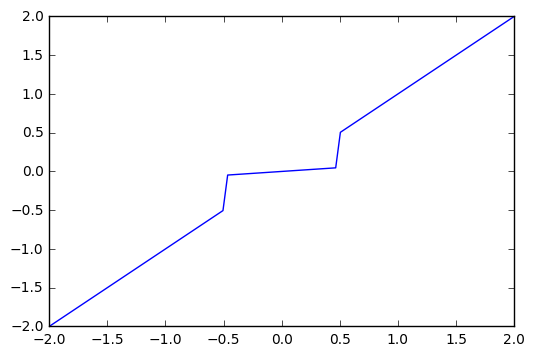

In [22]:
# leaky piecewise linear function

x = np.linspace(-2.0, 2.0, 100)

idxs = (abs(x) > 0.5).astype('int')
zeroed_out = x * idxs
residual = 0.1 * x * (1 - idxs)
y = zeroed_out + residual

plt.plot(x, y)
plt.show()

In [23]:
thresh = 2
alpha = 0.1

x = K.variable([1, 2, 3, 0, -1, 4, 9, 1, 9])

idxs = (K.abs(x) > thresh)
zeroed_out = x * idxs
residual = alpha * x * (1 - idxs)

print (zeroed_out + residual).eval()

[ 0.1  0.2  3.   0.  -0.1  4.   9.   0.1  9. ]


In [24]:
from keras.activations import softmax, sigmoid
from scipy.fftpack import dct, idct

# lambda to compute MSE between 2 vectors
def mse_lambda(vects):
    x, y = vects
    return K.mean(K.square(x - y))

# freeze weights for stacked training
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

# we generate a new optimizer of the same kind for every model
# we train
def opti():
    #return Adam(lr = 0.0002, beta_1 = 0.5)
    return Adadelta()

input_dim = (WINDOW_SIZE, 1)
input_size = np.prod(input_dim)
bottleneck_size = WINDOW_SIZE / 4


tau = K.variable(1.0, name = 'temperature')
anneal_rate = 0.02
min_temperature = 0.1
    

def linear_upsample_1d(x):
    r = T.repeat(x, 2, axis = 1)
    s = T.roll(r, -1, axis = 1)
    u = ((r[:, :-1] + s[:, :-1]) / 2.0)
    u = T.concatenate((u, r[:, -1:]), axis = 1)
    return u
def linear_upsample_shape(shape):
    return (shape[0], shape[1] * 2, shape[2])

def LinearUpSampling1D():
    return Lambda(linear_upsample_1d, output_shape = linear_upsample_shape)



BNORM_GEN = False
BNORM_DSC = False

thresh = 0.5
alpha = 0.1
def leaky_piecewise_linear(x):
    return K.maximum(1.0 - K.abs(x), -0.01 * K.abs(x))
    #idxs = (K.abs(x) > thresh)
    #zeroed_out = x * idxs
    #residual = alpha * x * (1 - idxs)
    #return zeroed_out + residual

def activation():
    #return Activation('linear')
    #return PReLU(init = 'he_normal')
    #return Lambda(leaky_piecewise_linear)
    #return ELU()
    return LeakyReLU(0.3)
    
res_init = 'he_uniform'

def residual_block(output_dim = 64, filt_size = 5, conv = True):
    def f(input):
        #bn1 = BatchNormalization()(input)
        #act1 = activation()(bn1)
        
        conv1 = input
        conv1 = Convolution1D(output_dim, filt_size, border_mode = 'same',
                          init = res_init, activation = 'linear',
                          bias = True)(conv1)
        if (BNORM_GEN): conv1 = BatchNormalization()(conv1)
        conv1 = activation()(conv1)
                
        conv2 = conv1
        conv2 = Convolution1D(output_dim, filt_size, border_mode = 'same',
                          init = res_init, activation = 'linear',
                          bias = True)(conv2)
        
        #'''
        residual = conv2
        if (conv):
            shortcut = Lambda(lambda x : K.repeat_elements(x, output_dim, axis = -1),
                              output_shape = (lambda s : (s[0], s[1], output_dim)))(input)
        else:
            shortcut = input
        
        m = merge([shortcut, residual], mode = 'sum')
        return m
    
    return f


# total # layers: NUM_RES_BLOCKS * 4
NUM_RES_BLOCKS = 8
NBINS = 101
nselect = K.variable(511, dtype = 'int32')
NCHAN = 32
TIMES_DOWNSAMPLE = 2
FILT_SIZE = 9
FILT_MID = FILT_SIZE / 2 + 1


def dct_weights(n):
    weights = dct(np.eye(n), norm = 'ortho')
    bias = np.zeros(n)
    return [weights, bias]

def idct_weights(n):
    weights = idct(np.eye(n), norm = 'ortho')
    bias = np.zeros(n)
    return [weights, bias]

    
# ---------------------------------------------------------------------------
# autoencoder: takes an audio window, compresses it, and tries to reconstruct it
# ---------------------------------------------------------------------------
def autoencoder_structure(dim):
    # convolutional layers have weight matrices of shape:
    #     (filter_length, 1, input_dim, nb_filter)
    # and biases of size (nb_filter,)
    
    # weights for an "replication convolution" (which just
    # replicates the input across all channels)
    #     filter of length 5, going from 1 channel to NCHAN
    def replicate_conv():
        weights = np.zeros((FILT_SIZE, 1, 1, NCHAN))
        weights[FILT_MID] = np.ones((1, 1, NCHAN))
        weights += np.random.uniform(-0.01, 0.01, weights.shape)
        biases = np.zeros((NCHAN,))
        return [weights, biases]
    
    
    # weights for an "average convolution" (which just
    # replicates the input across all channels)
    #     filter of length 1, going from NCHAN channels to 1
    def average_conv():
        weights = np.ones((1, 1, NCHAN, 1)) / float(NCHAN)
        weights += np.random.uniform(-0.01, 0.01, weights.shape)
        biases = np.zeros((1,))
        return [weights, biases]
    
    
    # weights for a "phase shift up" convolution (by default,
    # performs an upsample)
    #     filter of length 5, going from NCHAN to NCHAN * 2
    def shift_up_conv():
        weights = np.zeros((FILT_SIZE, 1, NCHAN, NCHAN * 2))
        weights[FILT_MID, 0] = np.repeat(np.eye(NCHAN), 2, axis = 1)
        weights += np.random.uniform(-0.01, 0.01, weights.shape)
        biases = np.zeros((NCHAN * 2,))
        return [weights, biases]
    
    
    # weights for a "phase shift down" convolution (by default,
    # performs an average)
    #     filter of length 5, going from NCHAN to NCHAN / 2
    def shift_down_conv():
        weights = np.zeros((FILT_SIZE, 1, NCHAN, NCHAN / 2))
        weights[FILT_MID, 0] = np.repeat(np.eye(NCHAN / 2), 2, axis = 0) / 2.0
        weights += np.random.uniform(-0.01, 0.01, weights.shape)
        biases = np.zeros((NCHAN / 2,))
        return [weights, biases]
    
    
    # weights for a "identity" convolution (by default,
    # does nothing to its input)
    #     filter of length 5, going from NCHAN to NCHAN
    #     (when combined with subsampling, this is a nearest-neighbor
    #      downsample)
    def identity_conv():
        weights = np.zeros((FILT_SIZE, 1, NCHAN, NCHAN))
        weights[FILT_MID, 0] = np.eye(NCHAN)
        weights += np.random.uniform(-0.01, 0.01, weights.shape)
        biases = np.zeros((NCHAN,))
        return [weights, biases]
    
    # identity matrix plus random noise
    def identity_mat(n):
        weights = np.eye(n) + np.random.uniform(-0.01, 0.01, (n, n))
        biases = np.zeros(n)
        return [weights, biases]
    
    
    
    
    enc_input = Input(shape = dim)
    enc = Reshape(dim, input_shape = dim)(enc_input)
    
    # increase number of channels via convolution
    repeated = Lambda(lambda x : K.repeat_elements(x, NCHAN, axis = -1),
                      output_shape = (lambda s : (s[0], s[1], NCHAN)))(enc)
    res = Convolution1D(NCHAN, FILT_SIZE, border_mode = 'same',
                          activation = 'linear',
                          init = res_init,
                          bias = True)(enc)
    res = activation()(res)
    enc = merge([repeated, res], mode = 'sum')
    
    # downsample
    for i in xrange(0, TIMES_DOWNSAMPLE):
        orig = enc
        
        res = Convolution1D(NCHAN, FILT_SIZE, border_mode = 'same',
                              init = res_init, activation = 'linear',
                              bias = True)(orig)
        if (BNORM_GEN): res = BatchNormalization()(res)
        res = activation()(res)
        
        enc = merge([orig, res], mode = 'sum')        
        enc = AveragePooling1D(2)(enc)

    
    # residual blocks
    for i in xrange(0, NUM_RES_BLOCKS):
        enc = residual_block(NCHAN, FILT_SIZE, False)(enc)
    
    # convolution across feature maps
    enc = Convolution1D(1, 1, border_mode = 'same',
                              bias = True,
                              weights = average_conv())(enc)

    enc = Reshape((bottleneck_size,))(enc)
    
    #enc = Dense(bottleneck_size, init = 'identity')(enc)
    enc = Activation('tanh')(enc)
    
    #enc = UniformQuantizer(NBINS, True)(enc)
    enc = Lambda(lambda x : CodeRound(NBINS)(x))(enc)
    
    enc = Model(input = enc_input, output = enc)
    
    
    
    
    
    dec_input = Input(shape = (bottleneck_size,))
    dec = Reshape((bottleneck_size,), input_shape = (bottleneck_size,))(dec_input)
    
    #dec = Dense(bottleneck_size, init = 'identity')(dec)
    
    dec = Reshape((bottleneck_size, 1,))(dec)
    # increase number of channels via convolution
    repeated = Lambda(lambda x : K.repeat_elements(x, NCHAN, axis = -1),
                      output_shape = (lambda s : (s[0], s[1], NCHAN)))(dec)
    res = Convolution1D(NCHAN, FILT_SIZE, border_mode = 'same',
                          activation = 'linear',
                          init = res_init,
                          bias = True)(dec)
    res = activation()(res)
    dec = merge([repeated, res], mode = 'sum')
    
    # residual blocks
    for i in xrange(0, NUM_RES_BLOCKS):
        dec = residual_block(NCHAN, FILT_SIZE, False)(dec)
        
    # upsample
    for i in xrange(0, TIMES_DOWNSAMPLE):
        up = LinearUpSampling1D()(dec)
        
        res = Convolution1D(NCHAN, FILT_SIZE, border_mode = 'same',
                              init = res_init, activation = 'linear',
                              bias = True)(up)
        if (BNORM_GEN): res = BatchNormalization()(res)
        res = activation()(res)
        
        dec = merge([up, res], mode = 'sum')
    
    # convolution across feature maps
    dec = Convolution1D(1, 1, border_mode = 'same',
                              activation = 'linear',
                              bias = True,
                              weights = average_conv())(dec)
    dec = Activation('tanh')(dec)
    
    dec = Model(input = dec_input, output = dec)
    
    return enc, dec

# ---------------------------------------------------------------------------
# discriminator: tries to differentiate between original and reconstructed samples
# ---------------------------------------------------------------------------
DSC_FILTS = 16
DSC_DENSE = 32
DSC_FILT_SIZE = 5
def discriminator_structure(dim):
    dsc = Sequential()
    
    # discriminator works in frequency space
    '''
    dsc.add(Reshape((WINDOW_SIZE,), input_shape = dim))
    transform = Dense(WINDOW_SIZE, weights = dct_weights(WINDOW_SIZE))
    dsc.add(transform)
    transform.trainable = False
    dsc.add(Reshape((WINDOW_SIZE, 1)))
    #'''
    
    #'''
    dsc.add(Convolution1D(DSC_FILTS, DSC_FILT_SIZE, border_mode='same',
                                    init = 'he_uniform',
                                    input_shape = dim, activation = 'linear'))
    if (BNORM_DSC): dsc.add(BatchNormalization())
    dsc.add(LeakyReLU(0.3))
    dsc.add(SpatialDropout1D(0.1))
    
    dsc.add(Convolution1D(DSC_FILTS, DSC_FILT_SIZE, border_mode='same',
                                    init = 'he_uniform',
                                    activation = 'linear'))
    if (BNORM_DSC): dsc.add(BatchNormalization())
    dsc.add(LeakyReLU(0.3))
    dsc_feats = dsc
    dsc.add(AveragePooling1D(2))
    dsc.add(SpatialDropout1D(0.1))
    
    dsc.add(Convolution1D(DSC_FILTS * 2, DSC_FILT_SIZE, border_mode='same',
                                    init = 'he_uniform',
                                    activation = 'linear'))
    if (BNORM_DSC): dsc.add(BatchNormalization())
    dsc.add(LeakyReLU(0.3))
    dsc.add(SpatialDropout1D(0.1))
    

    dsc.add(Convolution1D(DSC_FILTS * 2, DSC_FILT_SIZE, border_mode='same',
                                    init = 'he_uniform',
                                    activation = 'linear'))
    if (BNORM_DSC): dsc.add(BatchNormalization())
    dsc.add(LeakyReLU(0.3))
    dsc.add(SpatialDropout1D(0.1))
    
    dsc.add(Flatten())
    
    dsc.add(Dense(DSC_DENSE, init = 'he_uniform'))
    dsc.add(LeakyReLU(0.3))
    #'''
    
    dsc.add(Dense(1, activation = 'linear', init = 'he_uniform'))
    
    return dsc, dsc_feats


# construct autoencoder to be used in adversarial training
ac_input = Input(shape = input_dim)
ac_enc, ac_dec = autoencoder_structure(input_dim)
ac_embedding = ac_enc(ac_input)
ac_reconstructed = ac_dec(ac_embedding)

autoencoder = Model(input = [ac_input], output = [ac_reconstructed])
autoencoder.compile(loss = 'mean_squared_error', optimizer = Adam())

# construct discriminator: regular
dsc_input_dim = (WINDOW_SIZE, 1)
dsc_input = Input(shape = input_dim)
dsc_struct, dscfeat_struct = discriminator_structure(dsc_input_dim)
dsc_label = dsc_struct(dsc_input)
ac_dsc_label = dsc_struct(ac_reconstructed)

# get feature loss at intermediate layer of discriminator
dscfeat_inp = dscfeat_struct(ac_input)
dscfeat_rec = dscfeat_struct(ac_reconstructed)
dscfeat_mse = Lambda(mse_lambda, output_shape = (1,))([dscfeat_inp, dscfeat_rec])



clip_point = 0.0001
k = 0.5
def code_sparsity_constraint(placeholder, code):
    clipped = K.clip(K.abs(code), clip_point, 1.0)
    lk_norm = K.pow(clipped, k)
    loss = K.mean(lk_norm)
    
    return K.repeat_elements(loss.reshape((1,)), code.shape[0], 0)



def minimize_deviation(placeholder, code):
    v = K.var(code)
    clipped = K.clip(v, clip_point, 4.0)
    loss = K.sqrt(clipped)
    
    return K.repeat_elements(loss.reshape((1,)), code.shape[0], 0)
    


dct_mat = K.variable(dct(np.eye(WINDOW_SIZE), norm = 'ortho'))

def apply_dct(batch):
    reshaped = batch.reshape((1, batch.shape[0], batch.shape[1]))
    result = T.tensordot(dct_mat, reshaped, [[0], [2]])
    result = result.reshape((result.shape[0], result.shape[2])).T
    result = result.reshape((result.shape[0], result.shape[1]))
    return result


def mel_dct_loss(y_true, y_pred):
    dct_true = apply_dct(y_true)
    dct_pred = apply_dct(y_pred)
    
    # take average DCT loss over Mel bins
    loss = None
    for i in xrange(0, NUM_MEL_BINS):
        start = melIdxs[i]
        end = melIdxs[i + 1]
        
        sq = K.square(dct_pred[:, start:end] - dct_true[:, start:end])
        mse = K.mean(sq, axis = -1)
        mse = K.clip(mse, 0.000001, 10000.0)
        if (loss is None):
            loss = K.sqrt(mse) * BIN_WEIGHTS[i]
            #loss = mse
        else:
            loss += K.sqrt(mse) * BIN_WEIGHTS[i]
            #loss += mse
    loss /= float(NUM_MEL_BINS)
    
    return loss



def rmse(y_true, y_pred):
    mse = K.mean(K.square(y_pred - y_true), axis = -1)
    #return mse
    mse = K.clip(mse, 0.000001, 10000.0)
    return K.sqrt(mse)


# compile model
loss_weights = [250.0, 1.0, 25.0]
loss_functions = [rmse, 'mean_absolute_error', minimize_deviation]
n_recons = 1
n_discrim = 1
n_code = 1
n_other = 0
assert(n_recons + n_discrim + n_code + n_other == len(loss_weights))
assert(len(loss_weights) == len(loss_functions))


make_trainable(autoencoder, False)
discriminator = Model(input = [dsc_input], output = [dsc_label])
discriminator.compile(loss = ['mean_absolute_error'], optimizer = Adadelta())
discriminator.summary()

autoencoder.summary()

make_trainable(discriminator, False)
make_trainable(autoencoder, True)
model = Model(input = [ac_input], output = [ac_reconstructed] * n_recons + \
                                           [ac_dsc_label] * n_discrim + \
                                           [ac_embedding] * n_code + \
                                           [dscfeat_mse] * n_other)
model.compile(loss = loss_functions,
              loss_weights = loss_weights,
              optimizer = Adam())
model.summary()



X_train = np.copy(processedWindows)
ntrain = X_train.shape[0]
discrim_epoch = False


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 512, 1)        0                                            
____________________________________________________________________________________________________
sequential_1 (Sequential)        (None, 1)             271345      input_4[0][0]                    
Total params: 271,345
Trainable params: 271,345
Non-trainable params: 0
____________________________________________________________________________________________________
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 512, 1)        0                                            
___________________

In [25]:
def test_discriminator(discriminator, autoencoder, X, y, verbose = True):
    # verify discriminator was trained properly
    y_hat = discriminator.predict(X)
    y_hat[y_hat >= 0.5] = 1
    y_hat[y_hat < 0.5] = 0

    n_total = y.shape[0]
    n_correct = np.sum(np.ravel(y_hat) == y)

    acc = n_correct * 100.0 / n_total
    if (verbose):
        print "Discriminator accuracy: %0.02f pct (%d of %d) right"%(acc, n_correct, n_total)
    return acc

In [26]:
def autoencoderTest(waveFilename, prefix, autoencoder, verbose = True):
    [rate, data] = sciwav.read(waveFilename)
    data = data.astype(np.float32)
    processedWave, wparams = preprocessWaveform(data)
    windows = extractWindows(processedWave, STEP_SIZE, OVERLAP_SIZE)
    

    # first, write desired reconstruction
    transformed, tparams = preprocessWindows(windows)
    if (verbose):
        print transformed.shape
    
    desired = unpreprocessWindows(transformed, tparams)
    desired = reconstructFromWindows(desired, OVERLAP_SIZE, OVERLAP_FUNC)
    desired = unpreprocessWaveform(desired, wparams)
    desired = np.clip(desired, -32767, 32767)
    #sciwav.write(prefix + "_res_desired.wav", rate, desired.astype(np.int16))
    
    # then, run NN on transformed windows
    transformed, tparams = preprocessWindows(windows)
    
    transformed = np.reshape(transformed, (transformed.shape[0], WINDOW_SIZE, 1))
    autoencOutput = autoencoder.predict(transformed, batch_size = 128, verbose = (1 if verbose else 0))
    if (verbose):
        print autoencOutput.shape
    autoencOutput = np.reshape(autoencOutput, (autoencOutput.shape[0], WINDOW_SIZE))
    
    if (verbose):
        print autoencOutput.shape
    recons = unpreprocessWindows(autoencOutput, tparams)
    recons = reconstructFromWindows(recons, OVERLAP_SIZE, OVERLAP_FUNC)
    recons = unpreprocessWaveform(recons, wparams)
    recons = np.clip(recons, -32767, 32767)
    
    sciwav.write(prefix + "_output.wav", rate, recons.astype(np.int16))
    
    metrics = [
        np.max(desired),
        np.min(desired),
        np.max(recons),
        np.min(recons),
        mse(recons, desired),
        avgErr(recons, desired)
    ]
    
    if (verbose):
        print "Max/min desired:", metrics[0], metrics[1]
        print "Max/min recons: ", metrics[2], metrics[3]
        print waveFilename, " mse: ", metrics[4]
        print waveFilename, " avg err: ", metrics[5]
        
    return metrics

In [27]:
autoencoderTest("./SA1.WAV", "SA1_res_uninit_", autoencoder)

(112, 512)
112/112 [==============================] - 0s
(112, 512, 1)
(112, 512)
Max/min desired: 4899.0 -4013.0
Max/min recons:  4220.78 -130.155
./SA1.WAV  mse:  763968.0
./SA1.WAV  avg err:  576.829


[4899.0, -4013.0, 4220.7842, -130.15468, 763967.75, 576.82892]

In [28]:
# interleave numpy arrays of the same size along the first axis
def interleave(arr):    
    num = len(arr)
    
    r = np.empty(arr[0].shape)
    r = np.repeat(r, num, axis = 0)
    
    for i in xrange(0, num):
        r[i::num] = arr[i]

    return r

In [29]:
np.set_printoptions(formatter={'float_kind':'{:4f}'.format})

BATCH_SIZE = 128
NUM_BATCHES = ntrain / BATCH_SIZE
NUM_EPOCHS = 25

lead = "    "
d_loss = 0.0
a_losses = []
d_acc = 0.0
discrim_train_y = np.concatenate((np.ones(ntrain), np.zeros(ntrain)))

for epoch in range(NUM_EPOCHS):
    print "Epoch " + str(epoch + 1) + ":"

    # present batches randomly each epoch
    lis = range(0, ntrain, BATCH_SIZE)
    random.shuffle(lis)
    
    train_gen = True
    train_discrim = True
    
    # keep track of start time and current batch #
    i = 0
    startTime = time.time()
    for idx in lis:
        batch = X_train[idx:idx+BATCH_SIZE, :,  :]
        nbatch = batch.shape[0]
        
        a_losses = ["autoencoder not training"]
        d_loss = "discriminator not training"
        
        # if both are disabled, we re-enable both
        if (not train_gen and not train_discrim):
            train_gen = True
            train_discrim = True

        
        if (train_gen or n_discrim == 0):
            # train autoencoder ("generator")
            make_trainable(autoencoder, True)
            make_trainable(discriminator, False)
            
            a_y = [batch] * n_recons + \
                  [np.ones(nbatch)] * n_discrim + \
                  [np.zeros((nbatch, bottleneck_size))] * n_code + \
                  [np.zeros(nbatch)] * n_other
            a_losses = model.train_on_batch(batch, a_y)
            
            ad_loss = a_losses[-1]
        else:
            # re-enable generator training if disabled
            train_gen = True
        
        
        if (train_discrim and n_discrim > 0):
            # train discriminator
            make_trainable(autoencoder, False)
            make_trainable(discriminator, True)
            
            generated = autoencoder.predict(batch)
            discrim_batch_X = interleave([batch, generated])
            discrim_batch_y = interleave([np.ones(nbatch), np.zeros(nbatch)])

            d_loss = discriminator.train_on_batch(discrim_batch_X, discrim_batch_y)
            
            # turn loss into probability of predicting correctly
            #d_loss = np.exp(-d_loss)
            
            #if (d_loss > 0.8):
                # if discriminator is over 80% accurate, we don't train
                # the discriminator next batch
                #train_discrim = False
            #elif (d_loss < 0.5):
                # if discriminator is under 50% accurate, we don't train
                # the generator next batch
                #train_gen = False
        else:
            # re-enable discriminator training if disabled
            train_discrim = True
        
        # print statistics every 10 batches so we know stuff is still going down
        if (i % 10 == 0):
            printStr = "        \r" + lead + str(i * BATCH_SIZE) + ": " + str(d_loss) + " "
            print printStr,
            
            loss_arr = np.asarray(a_losses)
            print loss_arr,
            
            if (len(loss_weights) > 1 and len(loss_arr) > 1):
                for w in xrange(0, len(loss_weights)):
                    loss_arr[w + 1] *= loss_weights[w]
                print loss_arr,
            
        i += 1
    print ""
    
    # print elapsed time for epoch
    elapsed = time.time() - startTime
    print lead + "Total time for epoch: " + str(elapsed) + "s"   
    
    # ---------------------------------------------------------
    # evaluate discriminator on random samples every epoch
    # ---------------------------------------------------------
    startTime = time.time()
    print lead + "----------------"
    if (n_discrim > 0):
        NUM = 200
        rows = np.random.randint(X_train.shape[0], size = NUM)
        generated = autoencoder.predict(X_train[rows, :], verbose = 0)
        d_X = np.concatenate((X_train[rows, :], generated))
        d_y = np.concatenate((np.ones(NUM), np.zeros(NUM)))
        d_acc = test_discriminator(discriminator, autoencoder,
                                   d_X, d_y, verbose = False)

        print lead + "Evaluated the discriminator: " + str(d_acc) + "% d_acc"
        elapsed = time.time() - startTime
        print lead + "Total time for evaluation: " + str(elapsed) + "s"
    else:
        print lead + "No discriminator"
    
    
    # ---------------------------------------------------------
    # generate code histogram from said random samples
    # ---------------------------------------------------------
    NUM = 200
    rows = np.random.randint(X_train.shape[0], size = NUM)
    code = ac_enc.predict(X_train[rows, :], verbose = 0)
    
    print lead + "----------------"
    print lead + "Code histogram:"
    scalars = code.flatten()
    
    b = np.linspace(-1.0, 1.0, NBINS + 1)
    hist = np.histogram(scalars, bins = b)
    sample_hist_probs = hist[0].astype('float32')
    sample_hist_bins = hist[1].astype('float32')
    sample_hist_probs /= np.sum(sample_hist_probs)

    entropy = 0
    for i in sample_hist_probs:
        if (i < 1e-4): continue
        entropy += i * math.log(i, 2)
    entropy = -entropy
    
    zero_prob = sample_hist_probs[NBINS / 2]
    zero_prob = np.clip(zero_prob, 0.001, 0.999)
    mask_entropy = -(zero_prob * math.log(zero_prob, 2) + (1.0 - zero_prob) * math.log(1.0 - zero_prob, 2))
    
    print "       Entropy:", entropy
    print "       Zero prob:", sample_hist_probs[NBINS / 2]
    print "       Mask entropy:", mask_entropy
    print "       Pct. in last bins:", sample_hist_probs[0] + sample_hist_probs[-1]
    
    nnz = 0.0
    for i in xrange(0, code.shape[0]):
        r = np.round(code[i] * 1000.0) / 1000.0
        nnz += np.count_nonzero(r)
    nnz /= code.shape[0]
    print "       Avg # nonzero elts:", nnz
    
    # ---------------------------------------------------------
    # evaluate autoencoder on real data evey epoch
    # ---------------------------------------------------------
    startTime = time.time()
    print lead + "----------------"
    
    print lead + "Evaluating autoencoder..."
    metrics = autoencoderTest("./SA1.WAV", "SA1_res_reg_train_epoch" + str(epoch+1), autoencoder, verbose = False)
    
    print lead + "Max/min desired:", metrics[0], metrics[1]
    print lead + "Max/min recons: ", metrics[2], metrics[3]
    print lead + "MSE:     ", metrics[4]
    print lead + "Avg err: ", metrics[5]
    elapsed = time.time() - startTime
    print lead + "Total time for evaluation: " + str(elapsed) + "s"

Epoch 1:
    101120: 0.434404015541  [4.671542 0.012304 0.791059 0.032175] [4.671542 3.076097 0.791059 0.804385] 
    Total time for epoch: 423.487285137s
    ----------------
    Evaluated the discriminator: 60.5% d_acc
    Total time for evaluation: 1.05453300476s
    ----------------
    Code histogram:
       Entropy: 2.46674283057
       Zero prob: 0.177266
       Mask entropy: 0.674058576306
       Pct. in last bins: 0.0
       Avg # nonzero elts: 105.31
    ----------------
    Evaluating autoencoder...
    Max/min desired: 4899.0 -4013.0
    Max/min recons:  3858.17 -2670.38
    MSE:      9211.91
    Avg err:  54.6259
    Total time for evaluation: 0.136986017227s
Epoch 2:
    101120: 0.397434145212  [4.524831 0.011707 0.893175 0.028201] [4.524831 2.926630 0.893175 0.705027] 
    Total time for epoch: 378.203215837s
    ----------------
    Evaluated the discriminator: 63.75% d_acc
    Total time for evaluation: 0.263473033905s
    ----------------
    Code histogram:
       En

In [30]:
model.save('model_res_reg.h5')
autoencoder.save('auto_res_reg.h5')

discriminator.save('discrim_res_reg.h5')

import h5py

f = h5py.File('model_res_reg.h5', 'r+')
del f['optimizer_weights']
f.close()


In [31]:
'''from keras.models import load_model

objs = {'PhaseShift1D' : PhaseShift1D}

model = load_model('model_res_reg.h5', objs)
autoencoder = load_model('auto_res_reg.h5', objs)
discriminator = load_model('discrim_res_reg.h5', objs)
'''

"from keras.models import load_model\n\nobjs = {'PhaseShift1D' : PhaseShift1D}\n\nmodel = load_model('model_res_reg.h5', objs)\nautoencoder = load_model('auto_res_reg.h5', objs)\ndiscriminator = load_model('discrim_res_reg.h5', objs)\n"

In [32]:
enc = model.layers[1].layers
dec = model.layers[2].layers

In [33]:

'''
i = 0
print "-- Encoder --"
print ""
for e in enc:
    if type(e) is Convolution1D:
        i += 1
        print "Conv layer", i
        w = e.weights[0].eval()
        print "    Avg weight norm:", np.mean(np.abs(w))
        print "    Max weight norm:", np.max(np.abs(w))
        
        if (len(e.weights) == 1): continue
        b = e.weights[1].eval()
        print "    Avg bias norm:", np.mean(np.abs(b))
        print "    Max bias norm:", np.max(np.abs(b))
print ""

print "-- Decoder --"
print ""
for e in dec:
    if type(e) is Convolution1D:
        i += 1
        print "Conv layer", i
        w = e.weights[0].eval()
        print "    Avg weight norm:", np.mean(np.abs(w))
        print "    Max weight norm:", np.max(np.abs(w))
        
        if (len(e.weights) == 1): continue
        b = e.weights[1].eval()
        print "    Avg bias norm:", np.mean(np.abs(b))
        print "    Max bias norm:", np.max(np.abs(b))

#print [e.eval() for e in enc[-3].weights]
'''
0

0

In [34]:
NUM = 400
rows = np.random.randint(X_train.shape[0], size = NUM)
generated = autoencoder.predict(X_train[rows, :], verbose = 0)
d_X = np.concatenate((X_train[rows, :], generated))
d_y = np.concatenate((np.ones(NUM), np.zeros(NUM)))
d_acc = test_discriminator(discriminator, autoencoder,
                           d_X, d_y, verbose = False)

print lead + "Evaluated the discriminator: " + str(d_acc) + "% d_acc"

    Evaluated the discriminator: 56.125% d_acc


In [35]:
autoencoderTest("./SA1.WAV", "SA1_res_reg_", autoencoder)
autoencoderTest("./SX383.WAV", "SX383_res_reg_", autoencoder)
autoencoderTest("./fiveYears.wav", "fy_res_reg_", autoencoder)

(112, 512)
112/112 [==============================] - 0s
(112, 512, 1)
(112, 512)
Max/min desired: 4899.0 -4013.0
Max/min recons:  4593.89 -3621.89
./SA1.WAV  mse:  4111.67
./SA1.WAV  avg err:  40.3634
(93, 512)
93/93 [==============================] - 0s
(93, 512, 1)
(93, 512)
Max/min desired: 2961.0 -3057.0
Max/min recons:  2793.24 -2744.23
./SX383.WAV  mse:  2393.74
./SX383.WAV  avg err:  28.6961
(181, 512)
181/181 [==============================] - 0s     
(181, 512, 1)
(181, 512)
Max/min desired: 24636.0 -20122.0
Max/min recons:  21259.9 -19079.8
./fiveYears.wav  mse:  2.11132e+06
./fiveYears.wav  avg err:  1053.12


[24636.0, -20122.0, 21259.879, -19079.805, 2111324.5, 1053.1215]

In [36]:
all_embed = ac_enc.predict(X_train[:10000], batch_size = BATCH_SIZE, verbose = 1)

 9984/10000 [============================>.] - ETA: 0s

In [37]:
scalars = all_embed.flatten()
log_scalars = np.log((scalars + 1.0) / 2.0)

In [38]:
print np.mean(scalars)
print np.var(scalars)

-0.00780887
0.00109983


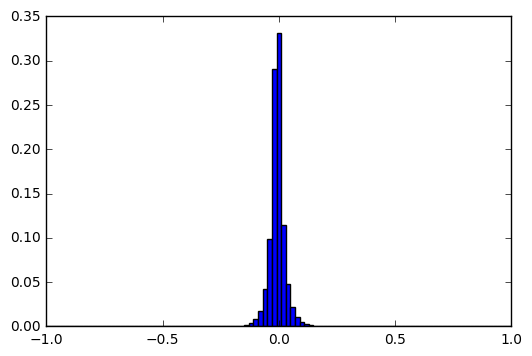

0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [39]:
hist = np.histogram(scalars, bins = np.linspace(-1.0, 1.0, NBINS + 1))
sample_hist_probs = hist[0].astype('float32')
sample_hist_bins = hist[1].astype('float32')
sample_hist_probs /= np.sum(sample_hist_probs)

sample_hist_width = 1 * (sample_hist_bins[1] - sample_hist_bins[0])
sample_hist_centers = (sample_hist_bins[:-1] + sample_hist_bins[1:]) / 2
plt.bar(sample_hist_centers, sample_hist_probs, align='center', width=sample_hist_width)
plt.show()

if (NBINS > 9):
    for i in xrange(1, 8):
        p = 0
        for j in xrange(0, i):
            p += sample_hist_probs[j]
            p += sample_hist_probs[-j - 1]
        print p



In [40]:
[rate, data] = sciwav.read("./SA1.WAV")
data = data.astype(np.float32)
processedWave, wparams = preprocessWaveform(data)
windows = extractWindows(processedWave, STEP_SIZE, OVERLAP_SIZE)

transformed, tparams = preprocessWindows(windows)

transformed = np.reshape(transformed, (transformed.shape[0], WINDOW_SIZE, 1))
embed = ac_enc.predict(transformed, batch_size = BATCH_SIZE, verbose = 1)

112/112 [==============================] - 0s


In [41]:
idx = 56
print np.sqrt(np.sum(np.sort(np.square(embed[idx]))[-1:])) / np.linalg.norm(embed[idx])
print np.count_nonzero(embed[idx])
print embed[idx]

r = np.copy(embed)
threshold = 0
#r = np.sign(r)
qnt_bins = NBINS
#r[r < threshold] = -1.0
#r[r >= threshold] = 1.0
#r = np.round(r)
#r[(r < 0) & (r > -0.93)] = -0.936508
#r[(r > 0) & (r < 0.93)] = 0.936508
r = (r + 1.0) / 2.0
r = np.round(r * float(qnt_bins - 1))
qnt = r[idx].astype('int')
r /= float(qnt_bins - 1)
r = (r * 2.0) - 1.0
#r = np.sign(r)

print r[idx]
#print qnt



autoencOutput = ac_dec.predict(r, batch_size = BATCH_SIZE, verbose = 1)
print autoencOutput.shape
autoencOutput = np.reshape(autoencOutput, (autoencOutput.shape[0], WINDOW_SIZE))

print autoencOutput.shape
recons = unpreprocessWindows(autoencOutput, tparams)

wav = reconstructFromWindows(recons, OVERLAP_SIZE, OVERLAP_FUNC)
wav = unpreprocessWaveform(wav, wparams)
wav = np.clip(wav, -32767.0, 32767.0)

sciwav.write("qnt_output_res_reg.wav", rate, wav.astype(np.int16))

idx = 45

0.280386
94
[-0.040000 0.000000 0.020000 0.060000 0.000000 0.040000 -0.020000 0.000000
 -0.040000 -0.020000 -0.060000 0.000000 0.000000 0.020000 0.040000
 -0.020000 -0.020000 -0.020000 -0.100000 -0.040000 -0.020000 0.000000
 0.040000 0.000000 0.040000 0.000000 0.000000 -0.040000 -0.020000 -0.060000
 -0.020000 0.020000 0.020000 0.020000 0.000000 -0.020000 -0.020000
 -0.080000 -0.040000 -0.020000 0.000000 0.040000 0.000000 0.040000 0.020000
 0.000000 -0.040000 -0.020000 -0.060000 -0.020000 0.000000 0.020000
 0.020000 0.020000 -0.020000 -0.020000 -0.100000 -0.020000 -0.020000
 0.000000 0.020000 0.020000 0.020000 0.020000 0.000000 -0.040000 -0.020000
 -0.040000 -0.020000 0.000000 0.000000 0.020000 0.000000 -0.020000
 -0.040000 -0.080000 -0.020000 -0.020000 0.020000 0.000000 0.040000
 0.000000 0.020000 0.000000 -0.040000 -0.040000 -0.040000 -0.020000
 0.020000 0.000000 0.020000 -0.020000 -0.020000 -0.040000 -0.080000
 -0.040000 -0.020000 0.020000 0.000000 0.040000 0.000000 0.020000 0.000000

In [42]:
b = np.linspace(-1.0, 1.0, NBINS + 1)
print b

h = np.histogram(scalars, bins = b)
print h[0]
print h[0].sum()
print h[1]
h = h[0].astype('float32')
h = h / h.sum()
print h

entropy = 0
for i in h:
    if (i < 1e-4): continue
    entropy += i * math.log(i, 2)
entropy = -entropy
print entropy

if (NBINS > 4):
    entropy = 0
    for idx in [0, 1, 2, -1, -2, -3]:
        i = h[idx]
        if (i < 1e-4): continue
        entropy += i * math.log(i, 2)
    entropy = -entropy
    print entropy

[-1.000000 -0.980198 -0.960396 -0.940594 -0.920792 -0.900990 -0.881188
 -0.861386 -0.841584 -0.821782 -0.801980 -0.782178 -0.762376 -0.742574
 -0.722772 -0.702970 -0.683168 -0.663366 -0.643564 -0.623762 -0.603960
 -0.584158 -0.564356 -0.544554 -0.524752 -0.504950 -0.485149 -0.465347
 -0.445545 -0.425743 -0.405941 -0.386139 -0.366337 -0.346535 -0.326733
 -0.306931 -0.287129 -0.267327 -0.247525 -0.227723 -0.207921 -0.188119
 -0.168317 -0.148515 -0.128713 -0.108911 -0.089109 -0.069307 -0.049505
 -0.029703 -0.009901 0.009901 0.029703 0.049505 0.069307 0.089109 0.108911
 0.128713 0.148515 0.168317 0.188119 0.207921 0.227723 0.247525 0.267327
 0.287129 0.306931 0.326733 0.346535 0.366337 0.386139 0.405941 0.425743
 0.445545 0.465347 0.485149 0.504950 0.524752 0.544554 0.564356 0.584158
 0.603960 0.623762 0.643564 0.663366 0.683168 0.702970 0.722772 0.742574
 0.762376 0.782178 0.801980 0.821782 0.841584 0.861386 0.881188 0.900990
 0.920792 0.940594 0.960396 0.980198 1.000000]
[     0      0  